In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
import matplotlib.colors as colors
import matplotlib.animation as animation
import matplotlib.ticker as mtick
from IPython.display import set_matplotlib_formats, HTML
set_matplotlib_formats('png', 'pdf')
plt.rcParams['figure.dpi'] = 100

In [3]:
import numpy as np
import scipy.special as spec
import scipy.integrate as inte
import sympy as sp
sp.init_printing()

In [4]:
# Variables mathématiques

r, omega = sp.symbols('r omega', positive = True) # Distance et fréquence
t = sp.symbols('t', real=True) # Temps
Ic = sp.symbols('I', complex=True) # Courant électrique

mu = sp.symbols("mu0", positive = True) # Perméabilité magnétique du vide
c = sp.symbols("c", positive=True)      # Célérité de la lumière dans le vide
k = omega/c                             # relation de dispersion

# Position du problème

Étant donné un fil électrique très long parcouru par un courant électrique $i$, on cherche à déterminer le champ magnétique créé par phénomène d'induction dans l'espace autour. On peut le détecter en approchant une boussole, de la limaille de fer ou d'autres aimants permanents du fil, voire approcher un autre fil électrique lui aussi parcouru par un courant.

# Implémentations en Python du champ magnétique et du courant électrique

Dans tout ce document, le courant et le champ magnétique seront représentés par des instances des classes `current` et `magField`, qui sont définies dans cette section. 

Chaque courant, par exemple, sera un objet de type `current`, dont les attributs, tels que `frequences`, `intensites`, `expr`, `func` contiendront les caractéristiques du courant, son expression mathématique, et une fonction numérique permettant de le calculer.

## Champ magnétique : classe `magField`

La cellule suivante définit les champs magnétiques comme une classe Python `magField`, dont les attributs sont notamment l'expression formelle du champ (`expr`), et la fonction numérique qui permet de calculer le champ en un point (`func`).

(**Attention code long**)

In [5]:
class magField:
    # Composante du potentiel vecteur associée à la pulsation omega
    A_component = -mu*Ic/4* \
        (sp.bessely(0,k*r) + sp.I*sp.besselj(0,k*r))*sp.exp(sp.I*omega*t)

    # Composante du champ magnétique associée à la pulsation omega
    B_component = - sp.diff(A_component, r).simplify()
    
    def bake_spectre(self, intens):
        '''
        Construit le champ magnétique
        '''
        c0 = self.cel
        mu0_v = 4e-7*np.pi
        
        spectr = zip(intens,self.pulsations)
        
        B_expr = sum([self.B_component.subs({Ic: cur, omega:om, c:c0, mu:mu0_v}) \
                for (cur,om) in spectr if (cur!=0 and om!=0)])
        B_expr_re = sp.re(B_expr)
        B_function = sp.lambdify((r, t), B_expr_re, 
            modules=['numpy',{"besselj":spec.jn, "bessely":spec.yn}])
        
        self.cplx_expr = B_expr
        self.expr = B_expr_re
        self.func = B_function
    
    def __init__(self, intens=None, puls=None, phas=None):
        
        self.cel = 3e8 # Célérité des ondes ; à modifier en fonction du milieu
        
        if not(intens is None):
            if not(phas is None):
                intens = np.asarray(intens)*np.exp(1j*np.asarray(phas))

            self.pulsations = puls
            self.frequences = puls/(2*np.pi)
            self.wavenumbers = self.pulsations/self.cel
            self.bake_spectre(intens)
        
    def draw(self, times, ani = False, custTitl = None):
        '''
        Construit les graphes du champ magnétique B aux temps donnés dans la liste
        "times"
        Si le drapeau 'ani' est True, alors entrer en mode "animation"
        '''
        func = self.func
        
        radii = np.linspace(rmin, rmax, 1000)

        fig = plt.figure(1, figsize=(8,5))
        ax = plt.axes()
        ax.set_xlim((rmin,rmax))
        ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))

        # Donne la légende 'temps'
        def legende(ti):
            return r'$t= {:.3e}$'.format(ti) + r"$\ \mathrm{s}$" 

        if not(ani):
            if hasattr(times, '__iter__'):
                for ti in times:
                    champ = func(radii, ti)
                    ax.plot(radii, champ, label=legende(ti))
            else:
                champ = func(radii, times)
                ax.plot(radii, champ, label=legende(times))
            ax.legend(loc='best')
        else:
            line, = ax.plot([], [], lw=2)
            time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

            interval = times[1] - times[0]
            animtime = 15
            fps = 30
            dt = interval/animtime # secondes vidéo par seconde réelle
            framenum = int(np.ceil(fps*animtime))

            ymax = func(radii,t0).max()
            ax.set_ylim((-1.3*ymax,1.3*ymax))

            def init():
                line.set_data([],[])
                time_text.set_text('')
                return line, time_text

            def animate(i):
                ti = dt*i/fps+t0
                legende_temps = legende(ti)
                champ = func(radii, ti)
                line.set_data(radii, champ)
                time_text.set_text(legende_temps)
                return line, time_text

        ax.grid(True)
        ax.set_xlabel("Distance $r$ (m)")
        ax.set_ylabel("Valeur du champ (T)")
        if custTitl:
            ax.set_title(custTitl)
        else:
            ax.set_title(r'Champ magnétique ' + r'$\mathbf{B}$' \
                         + ' créé par un courant variable')

        fig.tight_layout()

        if ani:
            anima = animation.FuncAnimation(fig, animate, init_func=init,
                        frames = framenum, interval = interval, blit = True)
            slef.writer = animation.FFMpegWriter(fps=fps, bitrate=1000)
            self.animation = anima
        else:
            self.graphe = fig
            
    def make_portrait(self, t, colmap='bone'):
        """
        Portrait du champ magnétique à l'instant t
        """
        wind = rmax

        func = self.func

        def field_func(x,y):
            r = np.sqrt(x*x+y*y)
            return func(r, t)*np.array([-y/r, x/r])

        Y, X = np.ogrid[-wind:wind:1000j, -wind:wind:1000j]
        BX, BY = field_func(X, Y)
        intensity = np.sqrt(BX**2+BY**2)

        fig, ax = plt.subplots(1, 1, figsize=(8,8))

        heat = ax.imshow(intensity, 
                         cmap=colmap,
                         norm=colors.LogNorm(), 
                         extent=[-wind, wind, -wind, wind], 
                         alpha=0.6)
        cbar = fig.colorbar(heat,
                    label='Intensité du champ ($T$)')

        strm = ax.streamplot(X,Y, BX, BY, 
            arrowstyle='->', color='w',
            linewidth=0.8, arrowsize=2,
            density=1.4)

        ax.grid(False)
        ax.set_aspect('equal')
        ax.set_xlim((-wind,wind))
        ax.set_ylim((-wind,wind))
        title_text = r'Champ magnétique $\mathbf{B}$ à '
        title_text += r"$t={:g}$".format(t)
        title_text += r" $\mathrm{s}$"
        ax.set_title(title_text)
        fig.tight_layout()

        self.portrait = fig

On pourrait éventuellement implémenter une classe `elecField` représentant le courant électrique... Le lecteur intrépride pourra s'y aventurer en répliquant le schéma adopté plus haut, ou en faisant une sous-classe de `magField`.

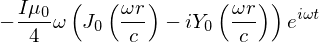

In [6]:
# Composante du champ électrique associée à la pulsation omega
A_component = magField().A_component
E_component = -sp.diff(A_component, t).expand().simplify()
E_component

## Courant électrique : classe `current`

La cellule suivante définit les courants électriques comme une classe Python `magField`, dont les attributs sont notamment l'expression formelle du champ (`expr`), et la fonction numérique qui permet de calculer le courant à un instant (`func`).

In [7]:
class Current:
    # Composante du courant électrique de pulsation omega
    cour_component = Ic*sp.exp(sp.I*omega*t)
    cour_component
    def bake_spectre(self, intens):
        """
        Calcule l'expression mathématique 'self.expr' et définit une fonction
        numérique 'self.func' permettant de calculer le courant à un instant.
        """
        spector = zip(intens,puls)
        cour = sum([self.cour_component.subs({Ic:i, omega:om}) \
                for i,om in spector ])
        cour_re = sp.re(cour)
        
        cour_func = sp.lambdify((t),cour_re,modules=['numpy'])
        
        self.expr = cour_re
        self.func = cour_func
    
    def bake_expr(self, expr):
        """
        Définit le courant selon son expression."""
        self.expr = expr
        self.func = sp.lambdify(t, expr, modules=['numpy'])
    
    def __init__(self, intens=None, puls=None, phas=None):
        """
        Étant donné le spectre (intensités et pulsations), initialise le courant
        en attribuant les fréquences/pulsations du courant, les intensités
        (complexes) associées. L'argument d'une intensité complexe correspond 
        au déphasage de la composante du courant associée.
        
        Si les phases sont précisées, elles sont ajoutées aux arguments des
        intensités."""
        if not(intens is None):
            if not(phas is None):
                intens = np.asarray(intens)*np.exp(1j*np.asarray(phas))

            self.intensities = intens
            self.pulsations = puls
            self.frequences = self.pulsations/(2*np.pi)

            self.bake_spectre(intens)
    
    def bake_fft(self, fs, N):
        dt = 1/fs
        sample_time = np.linspace(-N*dt,N*dt,N+1)
        samples = self.func(sample_time)
        
        self.intensities = np.fft.rfft(samples) # Intensités
        self.pulsations = np.fft.rfftfreq(N, d=1/fs)     # Pulsations associées
        self.frequences = self.pulsations/(2*np.pi)
    
    def draw(self, tmin, tmax, N=1000, custTitle=None):
        """
        Construit la représentation graphique de la fonction i(t),
        stockée dans l'attribut 'self.graphe'
        
        custTitle : titre optionnel à fournir
        """
        times = np.linspace(tmin, tmax, N)
        
        fig,ax=plt.subplots(1,1,figsize=(8,5))
        ax.grid(True)
        
        if custTitle:
            ax.set_title(custTitle)
        else:
            ax.set_title(r"Courant électrique")
        ax.plot(times, self.func(times))
        ax.set_xlabel(r"Temps $t$ $(\mathrm{s})$")
        ax.set_ylabel(r"Intensité du courant $i$ ($A$)")
        fig.tight_layout()
        self.graphe = fig
    
    def draw_fft(self):
        fig, (ax0,ax1) = plt.subplots(2,1, figsize=(8,8))
        
        xlbl = r'Pulsation $\omega$ ($\mathrm{Hz}$)'
        
        ax0.grid(True)
        ax0.set_xlabel(xlbl)
        ax0.set_ylabel(r"Amplitude $I(\omega)$ ($\mathrm{A}$)")
        ax0.plot(self.pulsations, np.abs(self.intensities))
        
        ax1.grid(True)
        ax1.set_xlabel(xlbl)
        ax1.set_ylabel(r"Phase $\phi(\omega)$ ($\mathrm{rad}$)")
        ax1.plot(self.pulsations, np.angle(self.intensities))
        
        ax0.set_title(r"Spectre en fréquence du courant $i(t)$")
        fig.tight_layout()
        
        self.graphe_fft = fig

# Exemples d'utilisation

## Données initiales

Entrez dans la variable `freqs` les fréquences du courant voulu, et dans `phas` les phases associées, et exécutez la cellule (`Ctrl + Entrée` sur le clavier) pour définir la fonction de champ :

In [8]:
freqs = np.array([n*1e8 for n in range(5,7)] + \
    [n*1e5 for n in range(2,5)])

puls = 2*np.pi*np.asarray(freqs) # Pulsations associées
intens = np.array([2,3,1,4,1]) # Intensités des composantes

phases = np.array([0,0,0,0,0]) # Phases des composantes

B_field = magField(intens, puls, phases)

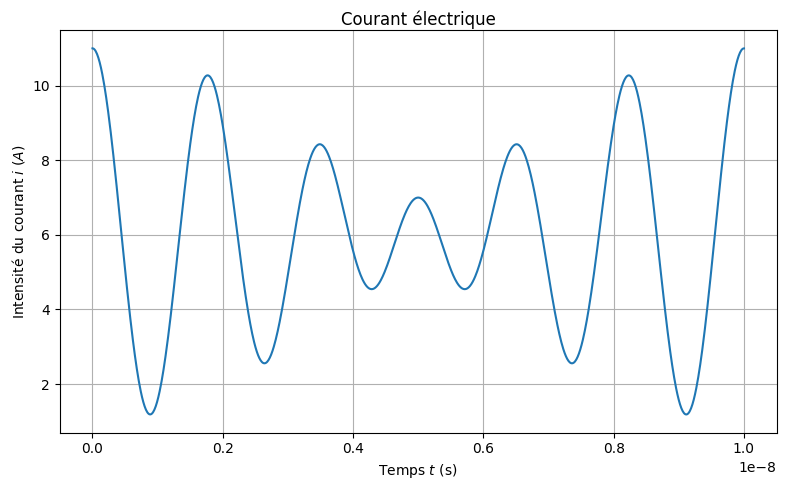

In [9]:
courant = Current(intens, puls, phases)
courant.draw(0,1e-8)

La cellule suivante définit les distances minimale et maximale pour lesquels tracer le profil du champ magnétique :

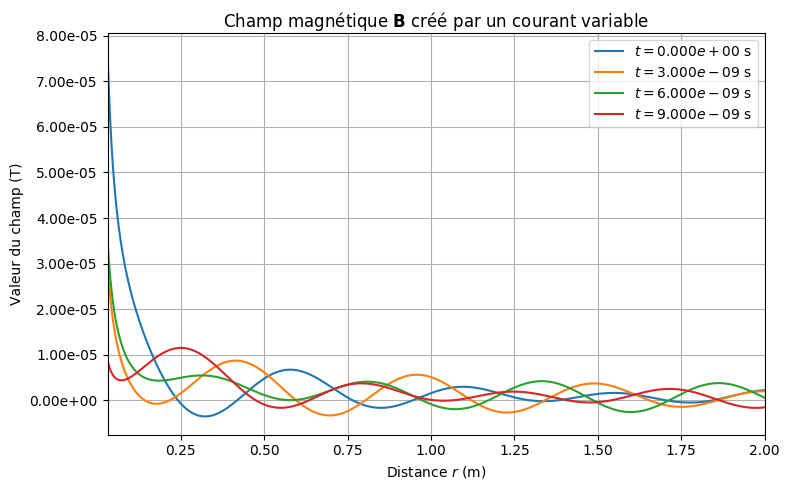

In [10]:
rmin = 0.03
rmax = 2

times = [1e-9*k for k in [0, 3, 6, 9]]

B_field.draw(times)

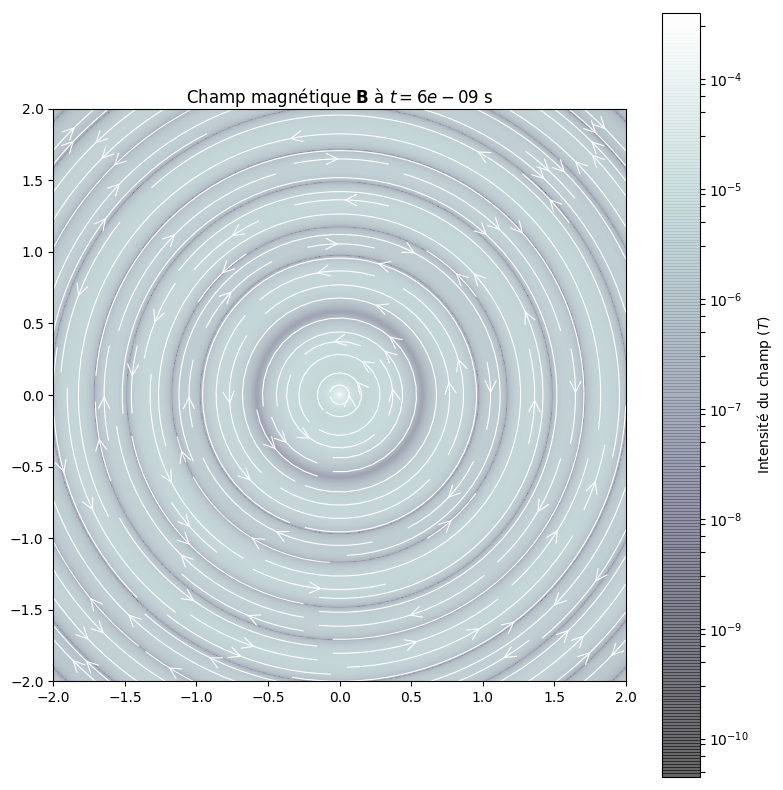

In [11]:
t_p = times[2]    # Temps auquel calculer le portrait du champ (pas de liste)

B_field.make_portrait(t_p)
B_field.portrait.savefig('portrait_champmag.pdf')
B_field.portrait.savefig('portrait_champmag.png')

## Animations

Modifiez cette cellule avec les fréquences que vous voulez utiliser pour l'animation:

In [12]:
freqs = np.array([n*1e8 for n in [2,6,8,14,15]] + \
    [n*1e6 for n in range(2,5)]\
        )

puls = 2*np.pi*np.array(freqs) # Pulsations associées

intens = [1,1,1,1,1,7,10,10] # Intensités des composantes
phases = [-0.3,0,-0.4,0,0,-0.1,0.2,0.3] # Phases des composantes

B_field = magField(intens, puls, phases)

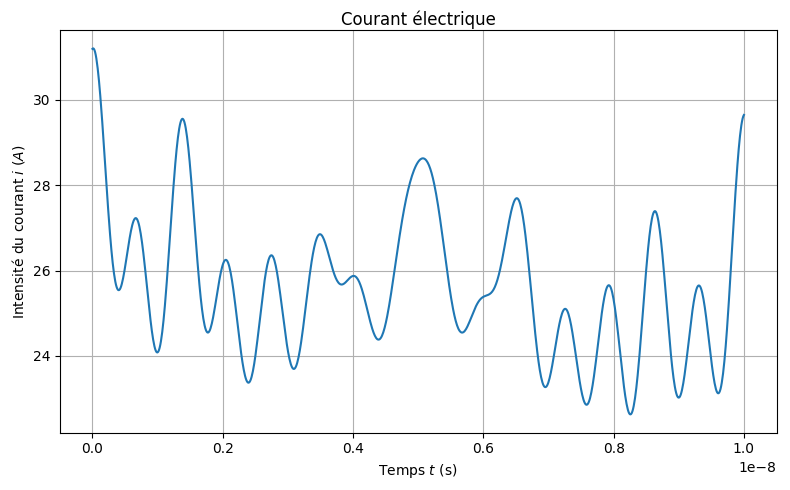

In [13]:
courant = Current(intens,puls,phases)
courant.draw(0,1e-8)

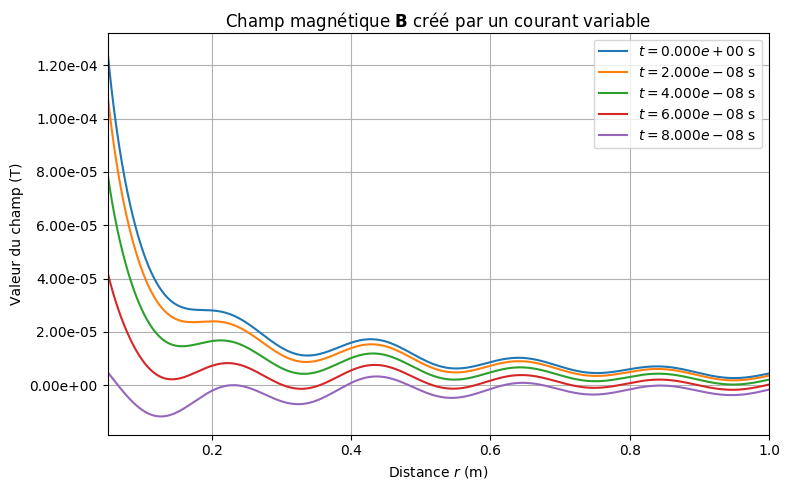

In [14]:
rmin = 0.05
rmax = 1

B_field.draw([1e-8*2*n for n in range(0,5)])

In [ ]:
times_an = [0, 1e-5]

B_field.draw(times_an, True)
B_field.animation.save("champmag_anim.mp4", writer=B_field.writer)

# Paquet d'ondes

In [15]:
def gaussienne(tau):
    tard = t - 0
    expr = sp.exp(-tard**2/(2*tau**2))*sp.cos(10*t/tau)
    out = Current()
    out.bake_expr(expr)
    return out

In [16]:
tau = 5e-14
N = 2**10 # Nombre d'échantillons
fs = 2**49 # Fréquence d'échantillonnage

courant = gaussienne(tau)
courant.expr

Courbe représentative du courant $i(t) = e^{-t^2/(2\tau^2)}\cos\left(\frac{t}{\tau}\right)$:

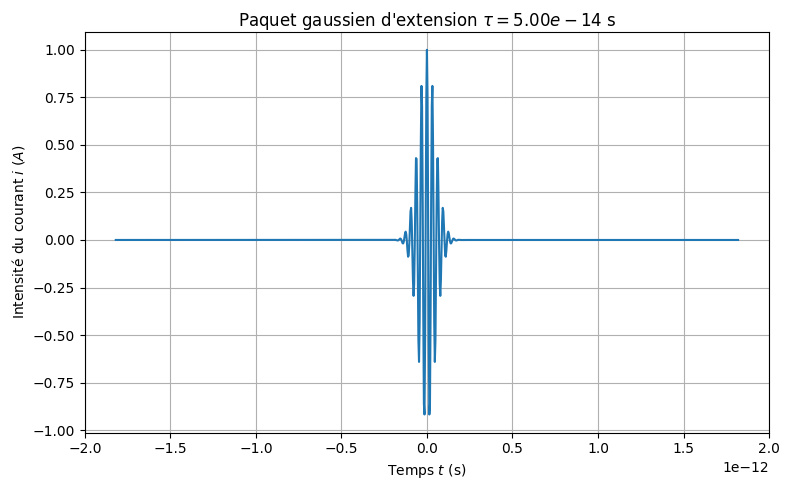

In [17]:
titros = r"Paquet gaussien d'extension $\tau = {:.2e}$ s".format(tau)
courant.draw(-N/fs,N/fs, N+1, custTitle = titros)

Construction du spectre du courant via la méthode `bake_fft`:

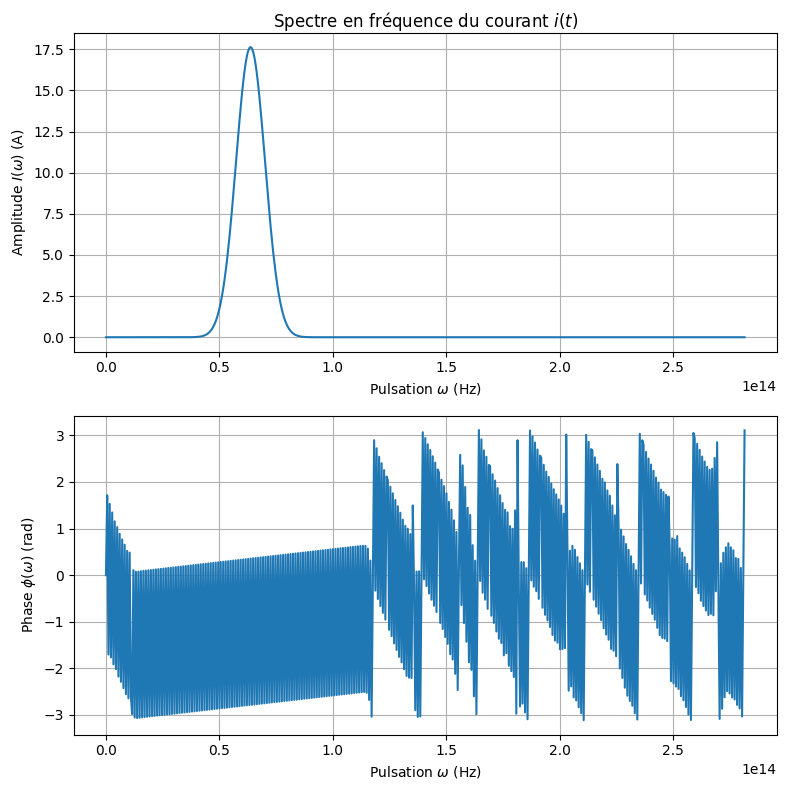

In [18]:
courant.bake_fft(fs, N)
courant.draw_fft()

In [19]:
intens = courant.intensities
puls = courant.pulsations

In [20]:
B_field = magField(intens, puls)

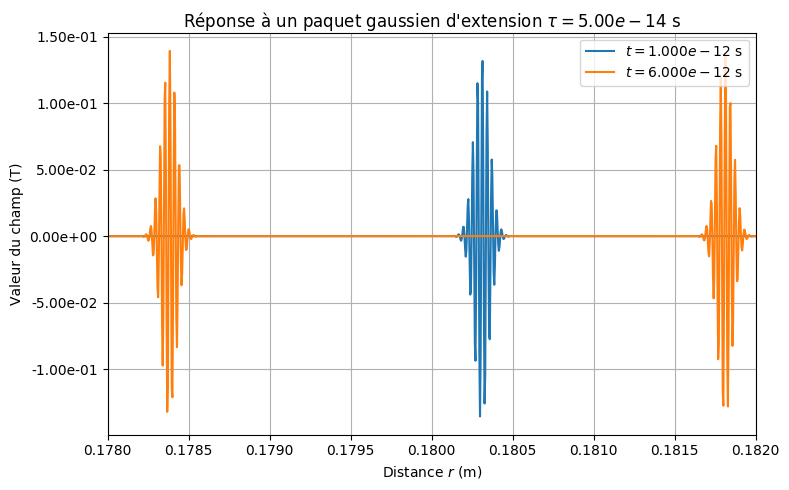

In [21]:
rmin = 0.178
rmax = 0.182

times = [1e-12*k for k in [1,6]]
titre_gauss = "Réponse à un paquet gaussien d'extension " + \
        r"$\tau={:.2e}$".format(tau) + " $\mathrm{s}$"
B_field.draw(times, custTitl=titre_gauss)

In [ ]:
times = [0,1e-10]

B_field.draw(times, True, 
    custTitl = "Propagation d'un paquet gaussien d'extension " + \
            r"$\tau = {:.2e}$".format(tau) + \
            "$\mathrm{s}$")
B_field.animation.save("paquet_gaussien.mp4", writer=B_field.writer)

# Théorie

Le champ magnétique $\mathbf{B}$ dérive d'un champ $\mathbf A$ appelé *potentiel vecteur* : $\mathbf{B} = \boldsymbol\nabla\wedge\mathbf{A}$. Par symétrie cylindrique, on a $\mathbf{B}(\mathbf r, t) = B(r,t)\mathbf{e}_\theta$, puis $\mathbf A(\mathbf r,t) = A(r,t)\mathbf e_z$.

Le potentiel vecteur $\mathbf{A} = A(r,t)\mathbf{e}_z$ est solution de l'équation d'onde

\begin{equation}
\Delta\mathbf A  - \frac{1}{c^2}\frac{\partial^2\mathbf A}{\partial t^2} = - \mu_0\mathbf{J}(r,t),
\end{equation}

avec $\mathbf J(\mathbf r,t)  = i(t)\delta(r)\delta(\theta)\mathbf{e}_z$ la densité volumique de courant, de sorte que pour toute surface $(\Sigma)$ traversée par le fil, on ait que le flux de $\mathbf J$ soit égal au courant parcourant le fil : $\iint_{(\Sigma)}\mathbf J(\mathbf r,t)\cdot\,\mathrm d\boldsymbol \sigma = i(t)$.


Pour un courant sinusoïdal $i(t) = I\exp(i\omega t)$, le potentiel s'écrit $\mathbf A(\mathbf r,t) = f(r)\exp(i\omega t)\mathbf e_z$ et l'équation aux dérivées partielles se réduit à

\begin{equation}
\frac{1}{r}\frac{\mathrm d}{\mathrm dr}\left(r \frac{\mathrm df}{\mathrm dr}\right) + k^2f(r) = -\frac{\mu_0 I}{2\pi r}\delta(r)
\end{equation}

avec $k=\dfrac{\omega}{c}$.

La solution prend la forme

$$
f(r) = -\frac{\mu_0 I}{4}\left(Y_0(kr)+i J_0(kr)\right)
$$

où $J_0,Y_0$ sont les 0-ièmes fonctions de Bessel de la première et seconde espèce, solutions de $$xy''(x) + y'(x) + xy(x) = 0.$$